In [ ]:
import numpy as np
import time
from Model import SVM, TISVM, RISVM, LOCSVM, LTISVM, LRISVM, TIRISVM, LTIRISVM, RIISVM, KNN, ResNetModel
#from DataLoader import load_data, train_valid_split
import ctypes
import torch
import pytorch_lightning as pl
import torch.utils.data as data_utils
from tqdm.autonotebook import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.io
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
import random

In [ ]:
def result_record(file, train_acc, valid_acc,scores,test_acc=0):
    file.write('Training: \n')
    file.write('accuracy: {:.3f}% \n'.format(train_acc * 100))
    file.write('---------------------------------------------\n')
    file.write('Validation: \n')
    file.write('accuracy: {:.3f}% \n'.format(valid_acc * 100))
    file.write('---------------------------------------------\n')
    file.write('\n')
    file.write('cross validation: \n')
    file.write('accuracy: {:.3f}% \n'.format(np.mean(scores) * 100))
    file.write('---------------------------------------------\n')
    if test_acc != 0:
        file.write('Testing: \n')
        file.write('accuracy: {:.3f}% \n'.format(test_acc * 100))
        file.write('---------------------------------------------\n')
    # file.write('The total number of support vectors: \n')
    # file.write(str(np.sum(svclassifier.n_support_)) + '\n')
    file.write('\n')

In [ ]:

## Load data
mat = scipy.io.loadmat('/home/grads/s/sant1/Desktop/cybermanufacturing/Dataset/Thermal_data_tensor.mat')
thermal_data = np.array(mat['Thermal_data_tensor'], dtype=np.int16)

ground_truth = np.load('/home/grads/s/sant1/Desktop/cybermanufacturing/Dataset/ground_truth.npy')
ground_truth = np.array(ground_truth, dtype=np.float16)

In [ ]:
# Labelling the data to 0 and 1, 0 for non-porous and 1 for porous
labels_gt = np.where(ground_truth > 1, 1, 0)
thermal_data.shape, labels_gt.shape

In [ ]:
# test_size = 0.2
# X_train, X_test, y_train, y_test = train_test_split(thermal_data, labels_gt, test_size=test_size, random_state=42)

# validation set is 10% of the training set

# test set is data model has never seen before

# validation set is used to tune the hyperparameters

# alternative we can use cross validation: split the data into k folds, train the model k times, each time using a different fold as the test set and the remaining k-1 folds as the training set

# finally present the average of the k models as the final model


In [ ]:
test_samples = 10
x_train, x_valid, y_train, y_valid = train_test_split(thermal_data[0:-1-test_samples,:], labels_gt[0:-1-test_samples], train_size=.8, random_state=50)
x_train_norm = x_train/np.max(thermal_data)
x_valid_norm = x_valid/np.max(thermal_data)
x_train_fin = x_train_norm.reshape(x_train_norm.shape[0],-1)
x_valid_fin = x_valid_norm.reshape(x_valid_norm.shape[0],-1)
y_test = labels_gt[-test_samples:]

In [ ]:
import seaborn as sns
sns.histplot(labels_gt, kde=True, legend=True, color='black', label='Full Data')
sns.histplot(y_valid,kde=True, legend=True, color='blue', label='Validation')   
sns.histplot(y_train,kde=True, legend=True, color='red')
sns.histplot(y_test,kde=True, legend=True, color='green')
plt.legend(['Full','Validation', 'Training', 'Test'])
plt.show()

In [ ]:
def svm_classifer(deg,thermal_data,labels_gt,test_samples=10):
    x_train, x_valid, y_train, y_valid = train_test_split(thermal_data[0:-1-test_samples,:], labels_gt[0:-1-test_samples], train_size=.9, random_state=5)
    x_train_norm = x_train/np.max(thermal_data)
    x_valid_norm = x_valid/np.max(thermal_data)
    x_train_fin = x_train_norm.reshape(x_train_norm.shape[0],-1)
    x_valid_fin = x_valid_norm.reshape(x_valid_norm.shape[0],-1)
    if test_samples>0:
        thermal_data_fin = thermal_data[-1-test_samples:-1,:]/np.max(thermal_data)
        thermal_data_fin = thermal_data_fin.reshape(thermal_data_fin.shape[0],-1)
    
    time_start = time.time()
    model = svm.SVC(gamma='auto', kernel='poly', degree=deg, coef0=1.0)
    
    scores=cross_val_score(model, thermal_data.reshape(thermal_data.shape[0],-1)/np.max(thermal_data), labels_gt, cv=5)
    print('Cross-validation scores: ', scores)
    model.fit(x_train_fin, y_train)
    y_predict = model.predict(x_train_fin)
    train_acc = accuracy_score(y_train, y_predict)
    y_eval=model.predict(x_valid_fin)
    eval_acc = accuracy_score(y_valid, y_eval)
    
    if test_samples>0:
        y_test=model.predict(thermal_data_fin)
        test_acc = accuracy_score(labels_gt[-1-test_samples:-1], y_test)
        print('Test accuracy: ', test_acc)
    time_stop = time.time()
    with open('SVM Polynomial Kernel', 'a') as f:
        f.write('SVM with polynomial kernel (degree={:.3f}) \n'.format(deg))
        f.write('Execution Time: {:.3f}s \n'.format(time_stop - time_start))
       
        if test_samples>0:
            result_record(f, train_acc, eval_acc, scores, test_acc)
        else:
            result_record(f, train_acc, eval_acc, scores )



In [ ]:
true_samples_indices=[index for index in range(len(labels_gt)) if labels_gt[index]==1]
false_samples_indices=[index for index in range(len(labels_gt)) if labels_gt[index]==0]
print(len(true_samples_indices), len(false_samples_indices))
min_samples = min(len(true_samples_indices), len(false_samples_indices))
true_samples_withlabels =[(thermal_data[i], 1) for i in true_samples_indices]
false_samples_withlabels =[(thermal_data[i], 0) for i in false_samples_indices]


if len(true_samples_indices) > len(false_samples_indices):
    random_true_samples = random.sample(true_samples_withlabels, min_samples)
    random_false_samples = false_samples_withlabels
    # randomly shuffle the data
    
    balanced_data = random_false_samples + random_true_samples
    np.random.shuffle(balanced_data)
else:
    random_true_samples = true_samples_withlabels
    random_false_samples = random.sample(false_samples_withlabels, min_samples)
    balanced_data = random_true_samples + random_false_samples
    np.random.shuffle(balanced_data)

X = np.array([sample[0] for sample in balanced_data]) # features
y = np.array([sample[1] for sample in balanced_data]) # labels
len(X), len(y)

In [186]:
thermal_data.shape, labels_gt.shape

((180, 8, 201, 201), (180,))

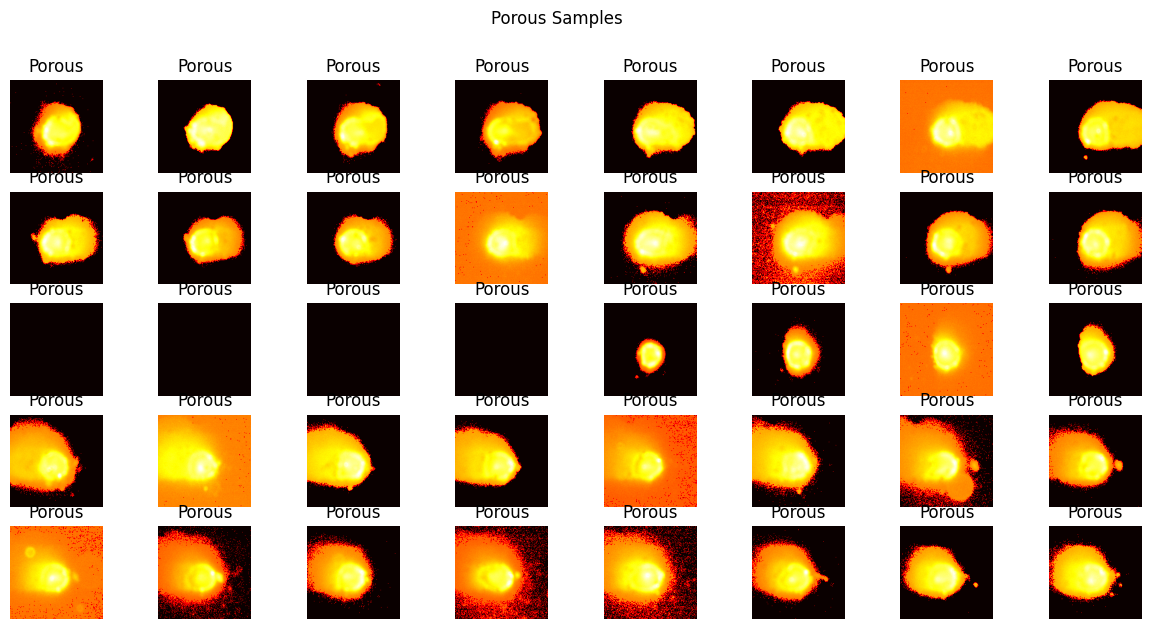

In [200]:
# plot images
fig, ax = plt.subplots(5, 8, figsize=(15, 7))
fig.suptitle('Porous Samples')
for i in range(5):
    for j in range(8):
        ax[i, j].imshow(thermal_data[true_samples_indices[i]][j], cmap='hot')
        ax[i, j].set_title('Porous')
        ax[i, j].axis('off')
   
plt.show()

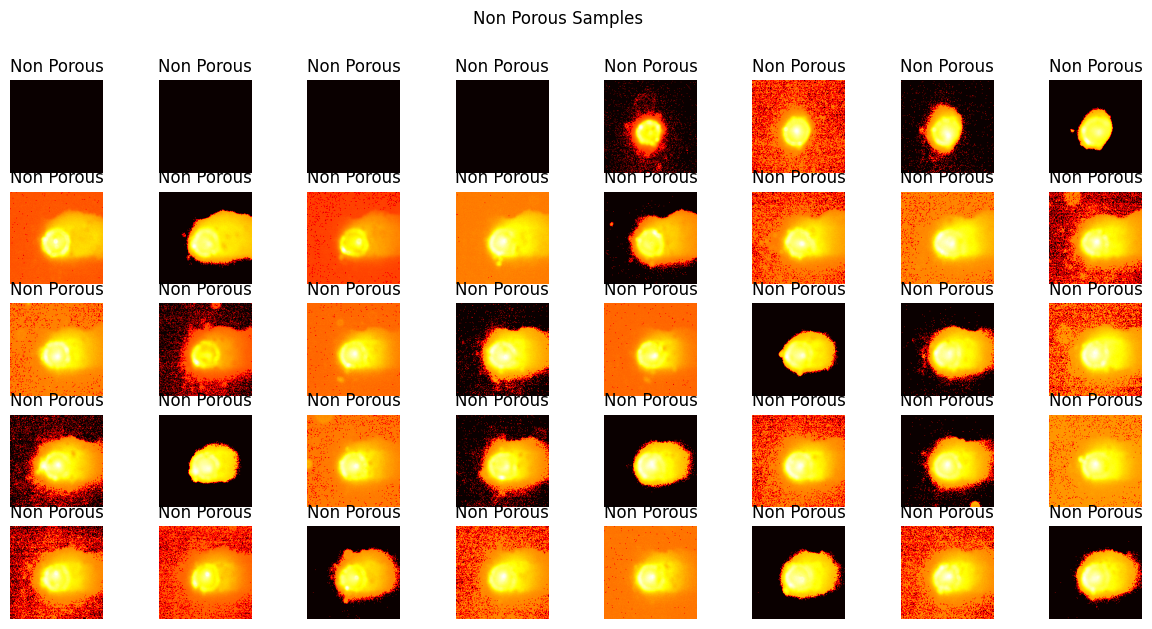

In [202]:
fig, ax = plt.subplots(5, 8, figsize=(15, 7))
fig.suptitle('Non Porous Samples')
for i in range(5):
    for j in range(8):
        ax[i, j].imshow(thermal_data[false_samples_indices[i]][j], cmap='hot')
        ax[i, j].set_title('Non Porous')
        ax[i, j].axis('off')
   
plt.show()

In [ ]:
sns.histplot(y, kde=True, legend=True, color='red', label='Balanced Data')

In [ ]:
# stratified k-fold cross-validation
# the folds are made by preserving the percentage of samples for each class

# the folds are approximately balanced in the sense that the number of samples in each class is approximately the same in each fold


# stratified a dataset using scikit-learn
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X, y)


for train_index, test_index in skf.split(X, y):
    sns.histplot(y[train_index],kde=True, legend=True, color='blue', label='Training')
    sns.histplot(y[test_index],kde=True, legend=True, color='red', label='Test')
    plt.legend(['Training', 'Test'])
    plt.show()

In [ ]:
def svm_classifer1(deg,X,y):
    skf = StratifiedKFold(n_splits=3)
    skf.get_n_splits(X, y)
    for train_index, test_index in skf.split(X, y):
        x_train, x_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        x_train_norm = x_train/np.max(X)
        x_valid_norm = x_valid/np.max(X)
        x_train_fin = x_train_norm.reshape(x_train_norm.shape[0],-1)
        x_valid_fin = x_valid_norm.reshape(x_valid_norm.shape[0],-1)
        X_data = X/np.max(X)
        X_data =X_data.reshape(X_data.shape[0],-1)
        
        time_start = time.time()
        model = svm.SVC(gamma='auto', kernel='poly', degree=deg, coef0=1.0)
        
        scores=cross_val_score(model, X_data, y, cv=5)
        print('Cross-validation scores: ', scores)
        model.fit(x_train_fin, y_train)
        y_predict = model.predict(x_train_fin)
        train_acc = accuracy_score(y_train, y_predict)
        y_eval=model.predict(x_valid_fin)
        eval_acc = accuracy_score(y_valid, y_eval)
        
        
        time_stop = time.time()
        with open('SVM Polynomial Kernel_proportional train and test sets', 'a') as f:
            f.write('SVM with polynomial kernel (degree={:.3f}) \n'.format(deg))
            f.write('Execution Time: {:.3f}s \n'.format(time_stop - time_start))
        
            result_record(f, train_acc, eval_acc, scores,0 )

In [ ]:
for degree in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
    svm_classifer1(degree,X,y)

In [ ]:
def tisvm_classifer(deg,X,y):
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, train_size=.7, random_state=54)
    x_train_norm = x_train/np.max(X)
    x_valid_norm = x_valid/np.max(X)
    X_data = X/np.max(X)
    X_data =X_data.reshape(X_data.shape[0],-1)
    x_train_fin = x_train_norm.reshape(x_train_norm.shape[0],-1)
    x_valid_fin = x_valid_norm.reshape(x_valid_norm.shape[0],-1)
    time1 = time.time()
    model = TISVM(degree=deg)
    svclassifier, train_acc = model.train(x_train_fin, y_train)
    eval_acc = model.evaluate(x_valid_fin, y_valid, svclassifier)
    cross_val_scores = cross_val_score(svclassifier, X_data, y, cv=10)
    #test_acc = model.evaluate(X_test, y[-1-test_samples:-1], svclassifier)
    time2 = time.time()
    with open('result TISVM.txt', 'a') as f:
        f.write('SVM with translational-invariant kernel (degree={:.3f}) \n'.format(deg) )
        f.write('Execution Time: {:.3f}s \n'.format(time2 - time1))
        result_record(f, train_acc, eval_acc,cross_val_scores, 0)

for deg in [2,3, 4, 5, 6, 7, 8, 9, 10]:
    tisvm_classifer(deg,X,y)

In [ ]:
# SVM with locality kernel (degree=8)
for idx in range(len(train_list)):
    time1 = time.time()
    model = LOCSVM(degree=8, filter=9)
    svclassifier, train_acc = model.train(x_train_fin[0:train_list[idx], :], y_train[0:train_list[idx]])
    eval_acc = model.evaluate(x_valid_fin[0:val_list[idx], :], y_valid[0:val_list[idx]], svclassifier)
    test_acc = model.evaluate(thermal_data_fin[0:test_list[idx], :], labels_gt[0:test_list[idx]], svclassifier)
    time2 = time.time()
    with open('result record.txt', 'a') as f:
        f.write('SVM with locality kernel (degree=8, EMNIST Letters dataset) \n')
        f.write('time to run this part: {:.3f}s \n'.format(time2 - time1))
        result_record(f, train_acc, eval_acc, test_acc, svclassifier)

In [184]:
def tisvm_classifer1(deg,X,y):
    skf = StratifiedKFold(n_splits=3)
    skf.get_n_splits(X, y)
    for train_index, test_index in skf.split(X, y):
        x_train, x_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        x_train_norm = x_train/np.max(X)
        x_valid_norm = x_valid/np.max(X)
        X_data = X/np.max(X)
        X_data =X_data.reshape(X_data.shape[0],-1)
        x_train_fin = x_train_norm.reshape(x_train_norm.shape[0],-1)
        x_valid_fin = x_valid_norm.reshape(x_valid_norm.shape[0],-1)
        time1 = time.time()
        model = TISVM(degree=deg)
        svclassifier, train_acc = model.train(x_train_fin, y_train)
        eval_acc = model.evaluate(x_valid_fin, y_valid, svclassifier)
        cross_val_scores = cross_val_score(svclassifier, X_data, y, cv=4)
        #test_acc = model.evaluate(X_test, y[-1-test_samples:-1], svclassifier)
        time2 = time.time()
        with open('proportional train and test sets TISVM.txt', 'a') as f:
            f.write('proportional train and test sets (degree={:.3f}) \n'.format(deg) )
            f.write('Execution Time: {:.3f}s \n'.format(time2 - time1))
            result_record(f, train_acc, eval_acc,cross_val_scores, 0)

for deg in [2,3, 4, 5, 6, 7, 8, 9, 10]:
    tisvm_classifer1(deg,X,y)

In [ ]:
# SVM with locality and rotational-invariant kernel (degree = 8)
x_train, x_valid, y_train, y_valid = train_test_split(X[0:-1-test_samples,:], y[0:-1-test_samples], train_size=.9, random_state=5)
x_train_norm = x_train/np.max(X)
x_valid_norm = x_valid/np.max(X)
X_data = X/np.max(X)
X_data =X_data.reshape(X_data.shape[0],-1)
x_train_fin = x_train_norm.reshape(x_train_norm.shape[0],-1)
x_valid_fin = x_valid_norm.reshape(x_valid_norm.shape[0],-1)
if test_samples>0:
    thermal_data_fin = X[-1-test_samples:-1,:]/np.max(X)
    thermal_data_fin = thermal_data_fin.reshape(thermal_data_fin.shape[0],-1)
time1 = time.time()
model = LRISVM(degree=8, filter=5)
svclassifier, train_acc = model.train(x_train_fin, y_train)
eval_acc = model.evaluate(x_valid_fin, y_valid, svclassifier)
test_acc = model.evaluate(thermal_data_fin, y[-1-test_samples:-1], svclassifier)
time2 = time.time()
with open('result record.txt', 'a') as f:
    f.write('SVM with locality and rotational-invariant kernel (degree=8) \n')
    f.write('time to run this part: {:.3f}s \n'.format(time2 - time1))
    result_record(f, train_acc, eval_acc,0, test_acc)

In [ ]:
# SVM with rotational-invariant kernel (degree = 8)
for idx in range(len(train_list)):
    time1 = time.time()
    model = RISVM(degree=8)
    svclassifier, train_acc = model.train(x_train_fin[0:train_list[idx], :], y_train[0:train_list[idx]])
    eval_acc = model.evaluate(x_valid_fin[0:val_list[idx], :], y_valid[0:val_list[idx]], svclassifier)
    test_acc = model.evaluate(thermal_data_fin[0:test_list[idx], :], labels_gt[0:test_list[idx]], svclassifier)
    time2 = time.time()
    with open('result record.txt', 'a') as f:
        f.write('SVM with rotational-invariant kernel (degree=8, EMNIST Letters dataset) \n')
        f.write('time to run this part: {:.3f}s \n'.format(time2 - time1))
        result_record(f, train_acc, eval_acc, test_acc, svclassifier)

In [ ]:
# SVM with rotational-invariant kernel (degree = 8, II)
for idx in range(len(train_list)):
    time1 = time.time()
    model = RIISVM(degree=8)
    svclassifier, train_acc = model.train(x_train_fin[0:train_list[idx], :], y_train[0:train_list[idx]])
    eval_acc = model.evaluate(x_valid_fin[0:val_list[idx], :], y_valid[0:val_list[idx]], svclassifier)
    test_acc = model.evaluate(thermal_data_fin[0:test_list[idx], :], labels_gt[0:test_list[idx]], svclassifier)
    time2 = time.time()
    with open('result record.txt', 'a') as f:
        f.write('SVM with rotational-invariant kernel (degree=8, II, EMNIST Letters dataset) \n')
        f.write('time to run this part: {:.3f}s \n'.format(time2 - time1))
        result_record(f, train_acc, eval_acc, test_acc, svclassifier)

In [ ]:
# SVM with translational & rotational-invariant kernel (degree = 8)
for idx in range(len(train_list)):
    time1 = time.time()
    model = TIRISVM(degree=8)
    svclassifier, train_acc = model.train(x_train_fin[0:train_list[idx], :], y_train[0:train_list[idx]])
    eval_acc = model.evaluate(x_valid_fin[0:val_list[idx], :], y_valid[0:val_list[idx]], svclassifier)
    test_acc = model.evaluate(thermal_data_fin[0:test_list[idx], :], labels_gt[0:test_list[idx]], svclassifier)
    time2 = time.time()
    with open('result record.txt', 'a') as f:
        f.write('SVM with translation & rotational-invariant kernel (degree=8, EMNIST Letters dataset) \n')
        f.write('time to run this part: {:.3f}s \n'.format(time2 - time1))
        result_record(f, train_acc, eval_acc, test_acc, svclassifier)

In [ ]:
# SVM with locality and translational-invariant kernel (degree = 8)
for idx in range(len(train_list)):
    time1 = time.time()
    model = LTISVM(degree=8, filter=7)
    svclassifier, train_acc = model.train(x_train_fin[0:train_list[idx], :], y_train[0:train_list[idx]])
    eval_acc = model.evaluate(x_valid_fin[0:val_list[idx], :], y_valid[0:val_list[idx]], svclassifier)
    test_acc = model.evaluate(thermal_data_fin[0:test_list[idx], :], labels_gt[0:test_list[idx]], svclassifier)
    time2 = time.time()
    with open('result record.txt', 'a') as f:
        f.write('SVM with locality and translational-invariant kernel (degree=8, EMNIST Letters dataset) \n')
        f.write('time to run this part: {:.3f}s \n'.format(time2 - time1))
        result_record(f, train_acc, eval_acc, test_acc, svclassifier)

In [ ]:
# SVM with translational & rotational-invariant & locality kernel (degree = 8)
for idx in range(len(train_list)):
    time1 = time.time()
    model = LTIRISVM(degree=8, filter=7)
    svclassifier, train_acc = model.train(x_train_fin[0:train_list[idx], :], y_train[0:train_list[idx]])
    eval_acc = model.evaluate(x_valid_fin[0:val_list[idx], :], y_valid[0:val_list[idx]], svclassifier)
    test_acc = model.evaluate(thermal_data_fin[0:test_list[idx], :], labels_gt[0:test_list[idx]], svclassifier)
    time2 = time.time()
    with open('result record.txt', 'a') as f:
        f.write(
            'SVM with translation & rotational-invariant & locality kernel (degree=8, EMNIST Letters dataset) \n')
        f.write('time to run this part: {:.3f}s \n'.format(time2 - time1))
        result_record(f, train_acc, eval_acc, test_acc, svclassifier)